In [10]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

In [11]:
data = np.concatenate(
[np.load('data\\binance_spot\\solfdusd_{}.npz'.format(date))['data'] for date in [20251011,20251012,]]
)
# 20251012,20251013,20251014,20251015
initial_snapshot = np.load('data\\binance_spot\\solfdusd_20251010_eod.npz')['data']
latency_data = np.concatenate(
[np.load('data\\binance_spot\\solfdusd_{}_latency.npz'.format(date))['data'] for date in [20251011,20251012,]]
)

In [15]:

@njit
def obi_mm(
    hbt,
    stat,
    half_spread,
    skew,
    c1,
    looking_depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
):
    asset_no = 0
    imbalance_timeseries = np.full(30_000_000, np.nan, np.float64)

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size

    t = 0
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    i = 0
    while hbt.elapse(interval) == 0:
        i+=1
        if i >100:return
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        mid_price = round((best_bid + best_ask) / 2.0, 2)

        sum_ask_qty = 0.0
        from_tick = max(depth.best_ask_tick, roi_lb_tick)
        upto_tick = min(int(np.floor(mid_price * (1 + looking_depth) / tick_size)), roi_ub_tick)
        for price_tick in range(from_tick, upto_tick):
            sum_ask_qty += depth.ask_depth[price_tick - roi_lb_tick]

        sum_bid_qty = 0.0
        from_tick = min(depth.best_bid_tick, roi_ub_tick)
        upto_tick = max(int(np.ceil(mid_price * (1 - looking_depth) / tick_size)), roi_lb_tick)
        for price_tick in range(from_tick, upto_tick, -1):
            sum_bid_qty += depth.bid_depth[price_tick - roi_lb_tick]

        imbalance_timeseries[t] = sum_bid_qty - sum_ask_qty

        # Standardizes the order book imbalance timeseries for a given window
        m = np.nanmean(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        s = np.nanstd(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        alpha = np.divide(imbalance_timeseries[t] - m, s)

        #--------------------------------------------------------
        # Computes bid price and ask price.

        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        # print("alpha",alpha)
        fair_price = mid_price + c1 * alpha

        normalized_position = position / order_qty

        reservation_price = fair_price - skew * normalized_position


        bid_price = min(np.round(reservation_price - half_spread), best_bid)
        ask_price = max(np.round(reservation_price + half_spread), best_ask)

        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size


        # print("mid_price",mid_price.real)
        # print("fair_price",fair_price.real)
        # print("reservation_price",reservation_price.real)
        # print("position",position.real)
        # print("--")
        # print("bid_price",bid_price.real)
        # print("ask_price",ask_price.real)
        # print("_______________")

        #--------------------------------------------------------
        # Updates quotes.

        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)

                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)

                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval

        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)

        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:

                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:

                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        t += 1

        if t >= len(imbalance_timeseries):
            raise Exception

        # Records the current state for stat calculation.
        stat.record(hbt)


import optuna
def objective(trial:optuna.Trial = None):
    roi_lb = 50
    roi_ub = 500
    asset = (
        BacktestAsset()
        .data(data)
        .initial_snapshot(initial_snapshot)
        .linear_asset(1.0)
        .intp_order_latency(latency_data)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00001, 0.0003)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(roi_lb)
        .roi_ub(roi_ub)
    )

    hbt = ROIVectorMarketDepthBacktest([asset])
    recorder = Recorder(1, 30_000_000)

    half_spread = 0.2
    skew = 0.1
    c1 = 0.1
    depth = 0.099  # 2.5% from the mid price
    interval = 1_000_000_000  # 1s
    window =  60 * interval  # 1hour
    order_qty_dollar = 50_0
    max_position_dollar = order_qty_dollar * 50
    grid_num = 1
    grid_interval = hbt.depth(0).tick_size

    # half_spread = trial.suggest_float("half_spread", 0.001, 1)
    # skew = trial.suggest_float("skew", 0.001, 1)
    # c1 = trial.suggest_float("c1", 0.01, 2)
    # depth = trial.suggest_float("depth", 1/1e4, 1/1e1)

    obi_mm(
        hbt,
        recorder.recorder,
        half_spread,
        skew,
        c1,
        depth,
        interval,
        window,
        order_qty_dollar,
        max_position_dollar,
        grid_num,
        grid_interval,
        roi_lb,
        roi_ub
    )
    hbt.close()

    stats = LinearAssetRecord(recorder.get(0)).stats(book_size=10_000_000)
    # 返回万分之
    return stats

stats = objective()


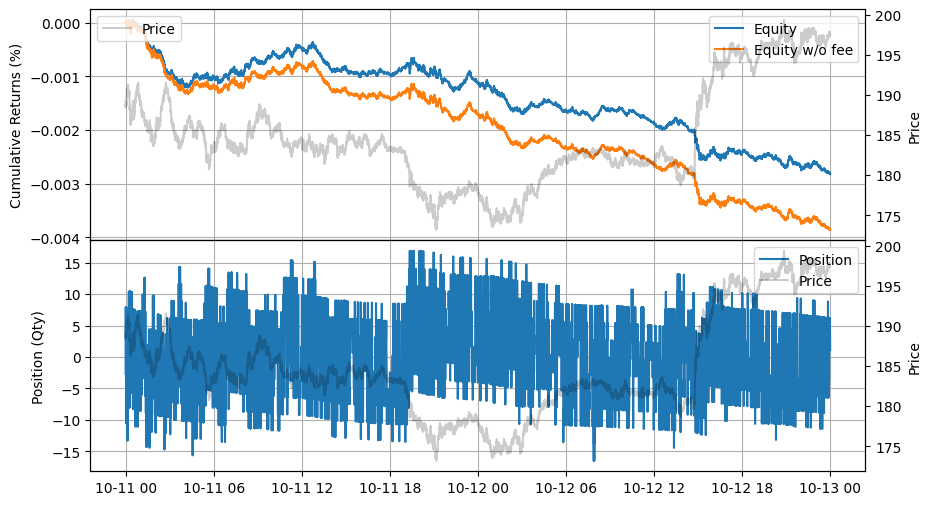

In [16]:
stats.plot()

In [17]:
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-11 00:00:00,2025-10-12 23:59:50,-31.221222,-42.231745,-0.000028,0.000029,10400.101858,0.520008,-0.979178,-0.000027,3026.759
